Part 1: Data Preparation

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')


print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

Handle for missing values :

In [92]:
df = df.dropna()

check and remove duplicates :

In [93]:

duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)



Number of duplicate rows: 240


Calculate correlation and remove unwanted features :

alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64


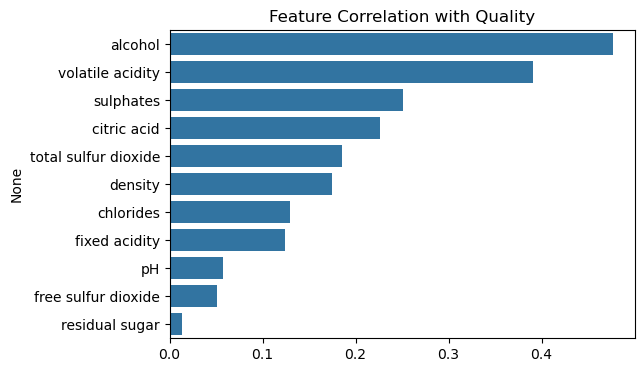

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


correlation = df.corr()['quality'].drop('quality')


correlation_sorted = correlation.abs().sort_values(ascending=False)

print(correlation_sorted)


plt.figure(figsize=(6,4))
sns.barplot(x=correlation_sorted.values, y=correlation_sorted.index)
plt.title("Feature Correlation with Quality")
plt.show()


In [95]:
threshold = 0.0
selected_features = correlation[correlation.abs() >= threshold].index.tolist()

print("Selected features:", selected_features)

Selected features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Binary classification: 0 = low quality (<=5), 1 = high quality (>=6)

In [96]:
df["quality_binary"] = df["quality"].apply(lambda q: 1 if q >= 6 else 0)

Visualize class distribution :

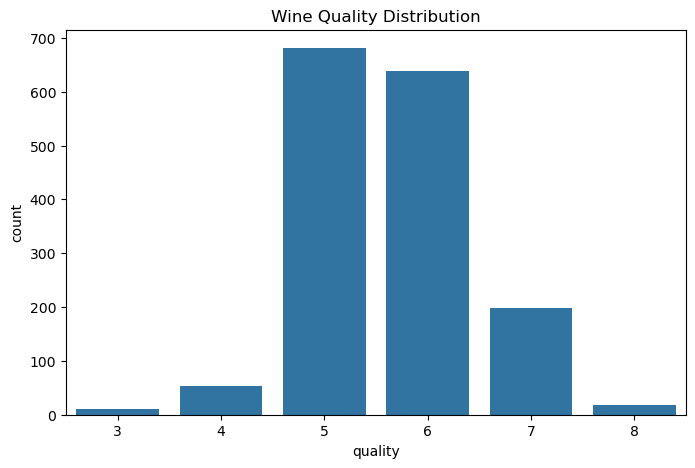

In [97]:
plt.figure(figsize=(8,5))
sns.countplot(x='quality', data=df)
plt.title('Wine Quality Distribution')
plt.show()

Split the data into training (80%) and testing sets (20%) : 

In [98]:
X = df.drop(["quality", "quality_binary"], axis=1)
y = df["quality_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Standardize features :

In [99]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Check class imbalance :

In [100]:
class_counts = y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print("Imbalance ratio:", imbalance_ratio)

Imbalance ratio: 1.1491935483870968


Part 2: Model Training and Evaluation :

In [101]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


svm_baseline = SVC(random_state=42)
svm_baseline.fit(X_train, y_train)


y_pred_baseline = svm_baseline.predict(X_test)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Baseline Precision:", precision_score(y_test, y_pred_baseline, average='weighted'))
print("Baseline Recall:", recall_score(y_test, y_pred_baseline, average='weighted'))
print("Baseline F1:", f1_score(y_test, y_pred_baseline, average='weighted'))


Baseline Accuracy: 0.7625
Baseline Precision: 0.7686620753164309
Baseline Recall: 0.7625
Baseline F1: 0.7625927770616039


Part 3 — K-Fold Cross-Validation :

In [102]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_baseline, X_train, y_train, cv=kf, scoring='accuracy')

print("Cross-validation accuracies:", cv_scores)
print("Average CV Accuracy:", np.mean(cv_scores))


Cross-validation accuracies: [0.77734375 0.73828125 0.7578125  0.765625   0.74509804]
Average CV Accuracy: 0.7568321078431373


Part 4 — Hyperparameter Tuning : 

In [103]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Define param grid for RandomizedSearchCV
param_dist = {
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

random_search = RandomizedSearchCV(
    SVC(), param_distributions=param_dist, n_iter=20, 
    scoring='accuracy', cv=5, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
print("Best params (RandomizedSearchCV):", random_search.best_params_)
print("Best score:", random_search.best_score_)

# GridSearchCV 
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(), param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best params (GridSearchCV):", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best params (RandomizedSearchCV): {'kernel': 'rbf', 'gamma': np.float64(0.01), 'C': np.float64(100.0)}
Best score: 0.7599785539215687
Best params (GridSearchCV): {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.7615441176470588


Part 5 — Handle Class Imbalance :

Using class_weight='balanced' :

In [106]:
svm_balanced = SVC(**grid_search.best_params_, class_weight='balanced', random_state=42)
svm_balanced.fit(X_train, y_train)
y_pred_balanced = svm_balanced.predict(X_test)

print("\nBalanced Class Weights Model Report:\n")
print(classification_report(y_test, y_pred_balanced))



Balanced Class Weights Model Report:

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       149
           1       0.84      0.70      0.76       171

    accuracy                           0.77       320
   macro avg       0.78      0.77      0.77       320
weighted avg       0.78      0.77      0.77       320



 Using manual weights :

In [115]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

manual_weights = {
    0 : 4,
    1 : 4
}

svm_manual = SVC(**grid_search.best_params_, class_weight=manual_weights, random_state=42)
svm_manual.fit(X_train, y_train)


y_pred_manual = svm_manual.predict(X_test)


print("Manual Weights SVM:")
print(classification_report(y_test, y_pred_manual, zero_division=0))


Manual Weights SVM:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       149
           1       0.84      0.78      0.81       171

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320




Final Model Metrics:
Accuracy: 0.80625
Precision: 0.808971786007266
Recall: 0.80625
F1 Score: 0.8064772727272727


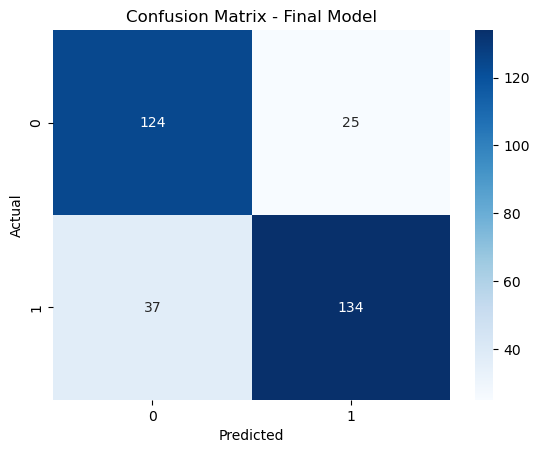

In [117]:
from sklearn.metrics import confusion_matrix

# Final model (best params from GridSearchCV with class_weight)
final_svm = SVC(**grid_search.best_params_ , class_weight=manual_weights , random_state=42)
final_svm.fit(X_train, y_train)
y_pred_final = final_svm.predict(X_test)

print("\nFinal Model Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_final, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_final, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
